# Solar radiance in spectral bands

In [96]:
%matplotlib inline
import os
import sys
import numpy as np
import scipy as sp
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.integrate as integrate
import pandas as pd

import imp

# get spectral band information for clirad and rrtmg
import rtmtools.clirad.sw.info as cliradswinfo
import rtmtools.clirad.lw.info as cliradlwinfo
import rtmtools.rrtmg.sw.info as rrtmgswinfo
import rtmtools.rrtmg.lw.info as rrtmglwinfo

import climatools.rrtmg as rrtmg
import climatools.clirad as clirad
import climatools.interp as climainterp

imp.reload(rrtmg)
imp.reload(clirad)
imp.reload(climainterp)



import matplotlib
import matplotlib.pyplot as plt

from IPython.display import HTML

In [115]:
irrad = pd.DataFrame([(.5 * sum(limit), irrad) 
                      for iband in rrtmg.wavenumber_bands().keys()
                      for limit, irrad in zip(rrtmg.wavenumber_bands()[iband], rrtmg.solar_irradiance()[iband])],
                     index = rrtmg.wavenumber_bands().keys(),
                     columns = ['mid-band wavenumber', 'solar irradiance'])
irrad.sort('mid-band wavenumber', inplace = True)

In [72]:
print('solar irradiance in RRTMG spectral bands')
irrad

solar irradiance in RRTMG spectral bands


,mid-band wavenumber,solar irradiance
14,1710,12.89
1,2925,12.11
2,3625,20.36
3,4325,23.73
4,4900,22.43
5,5650,55.63
6,6925,102.93
7,7875,24.29
8,10450,345.74
9,14425,218.19


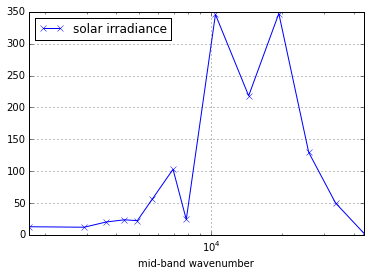

In [95]:
ax = irrad.plot(x = 'mid-band wavenumber', 
                                       y = 'solar irradiance', 
                                       marker = 'x', 
                                      logy = False, logx = True)

In [90]:
def fit_with_scipy():
    f = InterpolatedUnivariateSpline(irrad['mid-band wavenumber'], irrad['solar irradiance'], k = 1)
    irrad_clirad = pd.DataFrame({'mid-band wavenumber': clirad.midband_wavenumbers(),
                                'solar irradiance': f(clirad.midband_wavenumbers())})
    return irrad_clirad

irrad_clirad = fit_with_scipy()

#irrad_clirad = pd.DataFrame({'solar irradiance': climainterp.cubic_spline(irrad['mid-band wavenumber'], 
#                                                                          irrad['solar irradiance'],
#                                                                          clirad.midband_wavenumbers(region = 'sw')),
#                            'mid-band wavenumber': clirad.midband_wavenumbers(region = 's')})

In [116]:
print('Solar irradiance in CLIRAD spectral bands interpolated from RRTMG')
irrad_clirad

Solar irradiance in CLIRAD spectral bands interpolated from RRTMG


,mid-band wavenumber,solar irradiance
0,2700.0,12.254444
1,6300.0,79.743725
2,11240.0,320.390440
3,19643.0,336.548957
4,27885.0,108.194834
5,32051.5,65.123810
6,34210.5,46.964930
7,39766.0,22.060417
8,50793.0,-27.372049


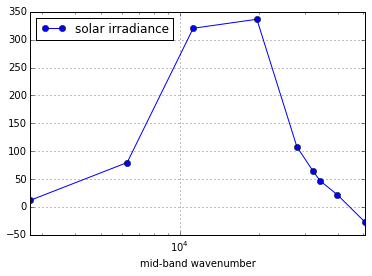

In [100]:
ax = irrad_clirad.plot(x = 'mid-band wavenumber', y = 'solar irradiance', 
                  marker = 'o', logx = True)

### Using solar spectrum used in CRD (line-by-line) to find radiance in CLIRAD's spectral bands

The point of finding the solar radiance in CLIRAD's spectral bands is that, because band 2 is actually made of 2 disconnected sub-bands, the solar radiances of these two sub-bands are used to weigh the extinctions to get *one* extinction for band 2.

In [114]:
# CRD's 'new.dat'
def solar_radiance_clirad_bands():
    path_lee = '/nuwa_cluster/home/jackyu/radiation/crd/SW/src/new.dat'
    crd_data = pd.read_csv(path_lee, 
                           sep = r'\s+',  
                           header = None,
                           names = ['wavenumber', 'irradiance'])
    crd_data.set_index('wavenumber', inplace = True)
    return {iband: [integrate.simps(crd_data.loc[limit[0]: limit[1], 'irradiance'], dx = 20.) for limit in limits]
           for iband, limits in clirad.wavenumber_bands().items()}

radiance_bands = solar_radiance_clirad_bands()

print('Solar radiance in CLIRAD band 2 sub-bands')
for (low_lim, high_lim), radiance in zip(clirad.wavenumber_bands()[2], radiance_bands[2]):
    print('band {} ~ {} cm-1'.format(low_lim, high_lim))
    print('radiance = {} W m-2 cm'.format(radiance))

Solar radiance in CLIRAD band 2 sub-bands
band 33333 ~ 35088 cm-1
radiance = 6.846816666666666 W m-2 cm
band 44444 ~ 57142 cm-1
radiance = 0.8120003333333334 W m-2 cm


In [37]:
HTML(
'''
<script>
code_show = true;
function code_toggle() {
if (code_show) {$('div.input').hide();} else {$('div.input').show();}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code"></form>
'''
)